In [1]:
# Standard library imports
import logging
import os
import subprocess
import json
import base64
from contextlib import redirect_stdout

# Third-party imports for data manipulation and analysis
import numpy as np
import pandas as pd
import random
from scipy import stats
from scipy.stats import norm
from numpy.linalg import inv

# Sklearn imports for model building and evaluation
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from geneticalgorithm import geneticalgorithm as ga
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.utils import resample
from statsmodels.graphics.tsaplots import plot_acf

# Machine learning libraries
from xgboost import XGBRegressor

# Libraries for optimization and parallel processing
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.backend import operators as op
from joblib import Parallel, delayed
from joblib import dump

# Utility for displaying in Jupyter notebooks
from IPython.display import display, Latex

# Serialization library
import pickle

# Other utilities
import shap
from tabulate import tabulate

In [2]:
# Load the data
data = pd.read_csv('./Book1.csv')
data

,a,s,d,f,g,h,j,j.1,t,y
0,1.0,276,37,10.65,0.773,1.70,75.4,60.0,0.816327,3.098604
1,1.0,276,37,10.65,0.773,1.70,75.4,60.0,4.557823,0.960135
2,1.0,276,37,10.65,0.773,1.70,75.4,60.0,6.122449,0.799515
3,1.0,276,37,10.65,0.773,1.70,75.4,60.0,7.278912,0.634045
4,1.0,276,37,10.65,0.773,1.70,75.4,60.0,9.523810,0.521572
...,...,...,...,...,...,...,...,...,...,...
177,1.0,313,38,11.10,0.773,1.75,75.4,25.0,74.211663,0.118145
178,1.0,313,38,11.10,0.773,1.75,75.4,25.0,74.902808,0.137382
179,1.0,313,38,11.10,0.773,1.75,75.4,25.0,75.853132,0.153535
180,1.0,313,38,11.10,0.773,1.75,75.4,25.0,76.889849,0.174333


In [3]:
# Calculate the statistical parameters for each column
statistics = pd.DataFrame({
    'Min': data.apply(np.min),
    'Max': data.apply(np.max),
    'Mean': data.apply(np.mean),
    'Median': data.apply(np.median),
    'Standard Deviation': data.apply(np.std),
    'Variance': data.apply(np.var),
    'Kurtosis': data.apply(lambda x: x.kurtosis()),
    'Skewness': data.apply(lambda x: x.skew()),
    '25th Percentile': data.apply(lambda x: x.quantile(0.25)),
    '75th Percentile': data.apply(lambda x: x.quantile(0.75)),
    'IQR': data.apply(stats.iqr)
})
statistics['Range'] = statistics['Max'] - statistics['Min']

# Transpose DataFrame to make each statistic a column
statistics = statistics.T

# Convert the DataFrame to LaTeX and display
statistics_latex = statistics.to_latex()
display(Latex(statistics_latex))
print(statistics_latex)

<IPython.core.display.Latex object>

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & a & s & d & f & g & h & j & j.1 & t & y \\
\midrule
Min & 0.700000 & 276.000000 & 27.000000 & 7.700000 & 0.732000 & 1.450000 & 48.000000 & 20.000000 & 0.000000 & 0.083309 \\
Max & 1.000000 & 575.000000 & 53.000000 & 11.100000 & 0.773000 & 2.000000 & 80.000000 & 60.000000 & 80.109890 & 3.098604 \\
Mean & 0.943956 & 335.730769 & 38.175824 & 10.586538 & 0.768264 & 1.711978 & 73.621978 & 29.348352 & 34.256022 & 0.382204 \\
Median & 1.000000 & 313.000000 & 37.000000 & 10.650000 & 0.773000 & 1.700000 & 75.400000 & 25.000000 & 30.550889 & 0.238727 \\
Standard Deviation & 0.116928 & 97.199404 & 5.823585 & 0.890516 & 0.011565 & 0.121314 & 7.805349 & 13.105983 & 23.074000 & 0.419381 \\
Variance & 0.013672 & 9447.724218 & 33.914141 & 0.793019 & 0.000134 & 0.014717 & 60.923473 & 171.766783 & 532.409495 & 0.175880 \\
Kurtosis & 0.632707 & 1.309234 & 2.605778 & 6.345404 & 5.191356 & 1.980610 & 6.837692 & 0.987353 & -1.091970 & 13.494199 \\
Skewness & -1.62045

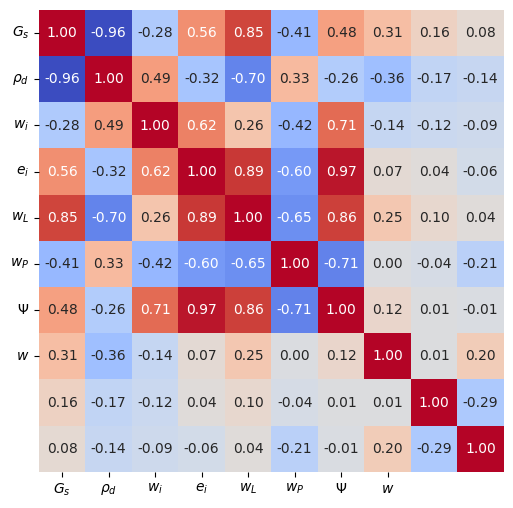

In [4]:
# Filter numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Calculate the Pearson correlation matrix
corr_matrix = data[numeric_cols].corr()

# Set the custom factor names
factor_names = ['$G_s$', '$\\rho_{d}$', '$w_{i}$', '$e_{i}$', '$w_L$', '$w_P$', '$\\Psi$', '$w$']

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=False, xticklabels=factor_names, yticklabels=factor_names)
heatmap.set_xticklabels(factor_names)
heatmap.set_yticklabels(factor_names, rotation=0)
plt.savefig('pearson_correlation.png', dpi=300)
plt.show()

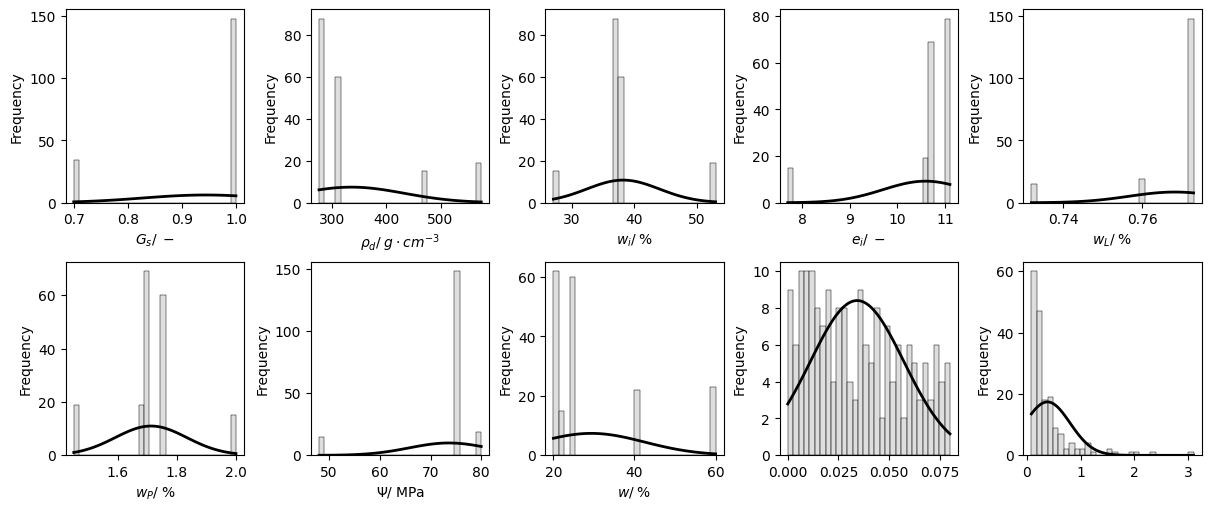

In [5]:
import warnings
warnings.filterwarnings('ignore')
#Calculate the number of rows needed based on the number of numeric columns
n_cols = 5 
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Create a new figure and axes with constrained layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5), constrained_layout=True)

# Flatten the axes array
axes = axes.flatten()

# Define the labels for your x-axes
x_labels = ['$G_s/\; -$', '$\\rho_{d}/\; g \cdot cm^{-3}$', '$w_{i}/\; \%$', '$e_{i}/\; -$', '$w_L/\; \%$', '$w_P/\; \%$', '$\\Psi/\; \mathrm{MPa}$', '$w/\; \%$']

# Ensure there are enough x-labels to match the number of numeric columns
if len(x_labels) < len(numeric_cols):
    x_labels.extend([''] * (len(numeric_cols) - len(x_labels))) 

# Iterate over each numeric column and create a histogram
for i, col in enumerate(numeric_cols):
    ax = axes[i]

    if i == len(numeric_cols) - 2:  # Checking for the column in which the values should be adjusted due to a unit change
        modified_data = data[col] / 1000  # Divide the column by 1000
    else:
        modified_data = data[col]

    # Estimate the binwidth
    binwidth = (modified_data.max() - modified_data.min()) / 30

    # Plot the histogram with the binwidth and without kde
    sns.histplot(modified_data, ax=ax, color='lightgrey', binwidth=binwidth, kde=False)

    # Calculate mean and standard deviation
    mu, std = stats.norm.fit(modified_data)

    # Plot the normal distribution with mean mu and standard deviation std
    x = np.linspace(modified_data.min(), modified_data.max(), 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p * modified_data.count() * binwidth, 'k', linewidth=2)  # scale pdf to match bin heights

    # Change the x-axis and y-axis label
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Frequency')  # Set y label as Frequency for all plots

# Remove extra subplots
if len(axes) > len(numeric_cols):
    for i in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[i])

plt.savefig('natural_clay_histograms.png', dpi=300)
plt.show()

In [6]:
# Split the data into features and target variable
X = data.drop('y', axis=1)
y = data['y']

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

 The best solution found:                                                                           
 [2.38000000e+02 2.29937888e-01 9.00000000e+00 2.03246308e+00]

 Objective function:
 0.29787766385994774


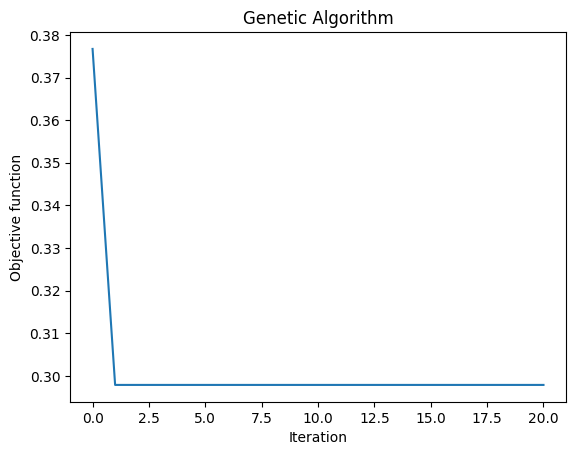

0:	learn: 0.4053239	total: 47.2ms	remaining: 11.2s
1:	learn: 0.3641764	total: 48.4ms	remaining: 5.71s
2:	learn: 0.3364121	total: 48.9ms	remaining: 3.83s
3:	learn: 0.3087871	total: 49.7ms	remaining: 2.91s
4:	learn: 0.2885036	total: 50.4ms	remaining: 2.35s
5:	learn: 0.2546992	total: 52.7ms	remaining: 2.04s
6:	learn: 0.2336720	total: 53.6ms	remaining: 1.77s
7:	learn: 0.2145425	total: 55.4ms	remaining: 1.59s
8:	learn: 0.1943368	total: 56.6ms	remaining: 1.44s
9:	learn: 0.1824346	total: 58.1ms	remaining: 1.32s
10:	learn: 0.1686201	total: 59.8ms	remaining: 1.23s
11:	learn: 0.1575633	total: 60.7ms	remaining: 1.14s
12:	learn: 0.1480304	total: 61.9ms	remaining: 1.07s
13:	learn: 0.1413678	total: 63ms	remaining: 1.01s
14:	learn: 0.1352340	total: 64.2ms	remaining: 954ms
15:	learn: 0.1255761	total: 65.4ms	remaining: 907ms
16:	learn: 0.1183623	total: 68.3ms	remaining: 888ms
17:	learn: 0.1119616	total: 69.6ms	remaining: 851ms
18:	learn: 0.1070913	total: 71.1ms	remaining: 819ms
19:	learn: 0.1003279	tot

In [8]:
def penalty_term(y_true, y_pred, threshold=0.001, base=3):
    residual = np.abs(y_true - y_pred)
    is_outside_threshold = residual > threshold
    residual_penalty = np.where(is_outside_threshold, np.exp(base * residual) - 1, 0)
    
    min_y_true = np.min(y_true)
    min_y_pred = np.min(y_pred)
    
    min_penalty = 0
    if min_y_pred < min_y_true:
        min_residual = min_y_true - min_y_pred
        min_penalty = np.exp(base * min_residual) - 1
    
    total_penalty = np.mean(residual_penalty) + min_penalty
    
    return total_penalty

def cv_fold(params, train_index, test_index, X, y):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    iterations, learning_rate, depth, l2_leaf_reg = params
    model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, random_seed=0)
    
    inner_mses = []
    
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]

    for inner_train_index, inner_val_index in inner_cv.split(train_X):
        inner_train_X, inner_val_X = train_X.iloc[inner_train_index], train_X.iloc[inner_val_index]
        inner_train_y, inner_val_y = train_y.iloc[inner_train_index], train_y.iloc[inner_val_index]
        
        model.fit(inner_train_X, inner_train_y, verbose=False)
        inner_y_pred = model.predict(inner_val_X)
        
        inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
        inner_mses.append(inner_mse)
        
    model.fit(train_X, train_y, verbose=False)
    y_pred = model.predict(test_X)
    
    mse = mean_squared_error(test_y, y_pred)
    penalty = penalty_term(test_y, y_pred)
    
    return np.mean(inner_mses) + mse + penalty

def fitness_function_wrapper(X, y):
    def fitness_function(params):
        outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
        outer_mses = Parallel(n_jobs=-1)(delayed(cv_fold)(params, train_index, test_index, X, y) for train_index, test_index in outer_cv.split(X))
        return np.mean(outer_mses)
    return fitness_function
    
# Define the variable bounds and types
varbound = np.array([[10, 300], [0.01, 0.3], [3, 10], [1, 5]])
vartype = np.array([['int'], ['real'], ['int'], ['real']])

fit_func = fitness_function_wrapper(X, y)

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fit_func, dimension=4, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None}, function_timeout=150.0)

    solver.run()
    best_params = {
        "iterations": int(solver.output_dict['variable'][0]),
        "learning_rate": solver.output_dict['variable'][1],
        "depth": int(solver.output_dict['variable'][2]),
        "l2_leaf_reg": solver.output_dict['variable'][3]
    }

    model = CatBoostRegressor(**best_params, random_seed=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

final_model_CatBoostRegressor_ph = CatBoostRegressor(**best_model_params, random_state=0)
final_model_CatBoostRegressor_ph.fit(X_train, y_train)
y_pred = final_model_CatBoostRegressor_ph.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

final_model_CatBoostRegressor_ph.save_model('final_model_CatBoostRegressor_ph.cbm')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")

best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_catboost_physics.csv', index=False)

results_df.to_csv('simulation_results_catboost_physics.csv', index=False)

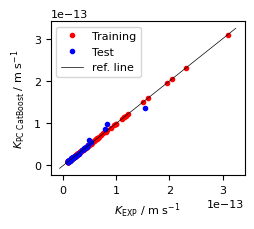

\begin{tabular}{lrrr}
\hline
       &       R2 &         MSE &        RMSE \\
\hline
 Train & 0.999994 & 1.1344e-32  & 1.06508e-16 \\
 Test  & 0.971044 & 2.23339e-29 & 4.72587e-15 \\
\hline
\end{tabular}


In [9]:
import catboost
# Create an instance of CatBoostRegressor
loaded_model = catboost.CatBoostRegressor()

# Load the model from the file
loaded_model.load_model('final_model_CatBoostRegressor_ph.cbm')
# Make predictions on the test set using the best model
#y_predtst = final_model_CatBoostRegressor_ph.predict(X_test) * 1e-13
#y_predtrn = final_model_CatBoostRegressor_ph.predict(X_train) * 1e-13

y_predtst = loaded_model.predict(X_test) * 1e-13
y_predtrn = loaded_model.predict(X_train) * 1e-13



# Adjust y-values
y_train_adj = y_train * 1e-13
y_test_adj = y_test * 1e-13

# Calculate metrics
r2_train_CatBoostRegressor_ph = r2_score(y_train_adj, y_predtrn)
r2_test_CatBoostRegressor_ph = r2_score(y_test_adj, y_predtst)
mse_train_CatBoostRegressor_ph = mean_squared_error(y_train_adj, y_predtrn)
mse_test_CatBoostRegressor_ph = mean_squared_error(y_test_adj, y_predtst)
rmse_train_CatBoostRegressor_ph = np.sqrt(mse_train_CatBoostRegressor_ph)
rmse_test_CatBoostRegressor_ph = np.sqrt(mse_test_CatBoostRegressor_ph)

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'R2': [r2_train_CatBoostRegressor_ph, r2_test_CatBoostRegressor_ph],
    'MSE': [mse_train_CatBoostRegressor_ph, mse_test_CatBoostRegressor_ph],
    'RMSE': [rmse_train_CatBoostRegressor_ph, rmse_test_CatBoostRegressor_ph]
}, index=['Train', 'Test'])

# Set figure size
plt.figure(figsize=(2.5, 2))

# Adjust the font size
plt.rc('font', size=8)

# Plotting both training and test data on one plot
plt.plot(y_train_adj, y_predtrn, 'ro', label='Training', markersize=3)
plt.plot(y_test_adj, y_predtst, 'bo', label='Test', markersize=3)

# Get the limits of the axes to ensure the 45-degree line spans the entire plot
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]

# Plot the 45-degree line
plt.plot(lims, lims, color='black', linestyle='-', label='ref. line', linewidth=0.5)

plt.xlabel(r'$K_{\text{EXP}}$ / m s$^{-1}$')
plt.ylabel(r'$K_{\text{PC CatBoost}}$ / m s$^{-1}$')
plt.legend(loc='upper left')
plt.savefig('regression_PH_catboost.png', bbox_inches='tight')
plt.show()

# Tabulate the metrics and print in LaTeX format
print(tabulate(metrics_df, tablefmt="latex", headers='keys', showindex=True))

In [10]:
# Create a DataFrame to hold the experimental values and predicted values
df = pd.DataFrame({
    'Experimental': y,  # Original experimental values
    'Predicted': final_model_CatBoostRegressor_ph.predict(X) * 1e-13,  # Predictions on the entire dataset
    'Train_Test_Indicator': 0  # Default to 0 (test set)
})

# Set Train_Test_Indicator to 1 for rows in the training set
df.loc[X_train.index, 'Train_Test_Indicator'] = 1

# Now df holds the experimental values, predicted values, and an indicator for train/test set
# and maintains the original order of the data

# To save this DataFrame to a CSV file:
df.to_csv('data_with_predictions.csv', index=False)

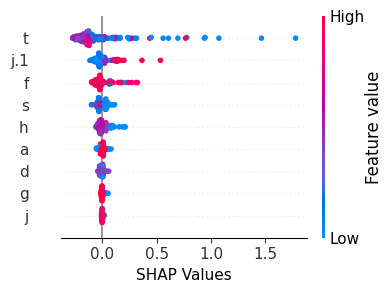

In [11]:
import matplotlib.pyplot as plt
import shap

# Assuming final_model_CatBoostRegressor_ph and X_train are already defined
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(X_train)

# Create the SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_size=(4, 3), show=False)

# Access the current Axes object
ax = plt.gca()

# Attempt to adjust the font size of the bar labels
for label in ax.get_yticklabels():
    label.set_fontsize(11)

# Customizing the x-axis label
plt.xlabel("SHAP Values", fontsize=11)

# If you want to save the SHAP plot
plt.savefig('shap_plot.png', bbox_inches='tight')

# Display the plot
plt.show()

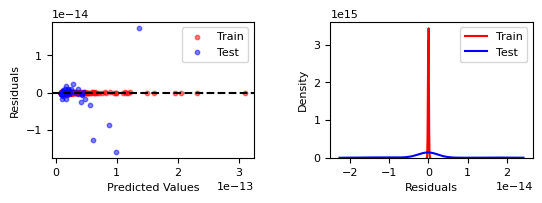

In [12]:
# Adjust y-values
y_train_adj = y_train * 1e-13
y_test_adj = y_test * 1e-13

# Make predictions on the test and train sets using the best model
y_predtst = loaded_model.predict(X_test) * 1e-13
y_predtrn = loaded_model.predict(X_train) * 1e-13

# Compute residuals
residuals_tst = y_test_adj - y_predtst
residuals_trn = y_train_adj - y_predtrn

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))

# Plot residual vs predicted values for both test and train sets
axs[0].scatter(y_predtrn, residuals_trn, alpha=0.5, color='red', label='Train', s=10)
axs[0].scatter(y_predtst, residuals_tst, alpha=0.5, color='blue', label='Test', s=10)
axs[0].axhline(y=0, color='black', linestyle='--')
axs[0].set_xlabel('Predicted Values', fontsize=8)
axs[0].set_ylabel('Residuals', fontsize=8)
axs[0].legend(fontsize=8)
axs[0].tick_params(axis='both', labelsize=8)

# Plot density of residual (test and train sets)
sns.kdeplot(residuals_trn, ax=axs[1], color='red', label='Train')
sns.kdeplot(residuals_tst, ax=axs[1], color='blue', label='Test')
axs[1].set_xlabel('Residuals', fontsize=8)
axs[1].set_ylabel('Density', fontsize=8)
axs[1].legend(fontsize=8)
axs[1].tick_params(axis='both', labelsize=8)

# Adjust the space between the subplots and display the plot
plt.tight_layout(pad=3.0)
plt.savefig('residual_PH_catboost.png', bbox_inches='tight')

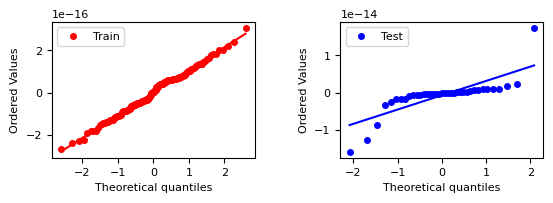

In [13]:
# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))

# Q-Q plot for training residuals
stats.probplot(residuals_trn, plot=axs[0], fit=True)
line = axs[0].get_lines()[0]
line.set_markerfacecolor('red')
line.set_markeredgecolor('red')
line.set_markersize(4)  # Set marker size to 4
line = axs[0].get_lines()[1]
line.set_color('red')
axs[0].legend(['Train'], loc='upper left', fontsize=8)
axs[0].tick_params(axis='both', labelsize=8)
axs[0].set_title('')

# Q-Q plot for testing residuals
stats.probplot(residuals_tst, plot=axs[1], fit=True)
line = axs[1].get_lines()[0]
line.set_markerfacecolor('blue')
line.set_markeredgecolor('blue')
line.set_markersize(4)  # Set marker size to 4
line = axs[1].get_lines()[1]
line.set_color('blue')
axs[1].legend(['Test'], loc='upper left', fontsize=8)
axs[1].tick_params(axis='both', labelsize=8)
axs[1].set_title('')

# Adjust the space between the subplots and display the plot
plt.tight_layout(pad=3.0)
plt.show()

In [14]:
# Calculating statistical evaluations for training residuals
mean_trn = np.mean(residuals_trn)
median_trn = np.median(residuals_trn)
variance_trn = np.var(residuals_trn)
std_dev_trn = np.std(residuals_trn)
skewness_trn = stats.skew(residuals_trn)
kurtosis_trn = stats.kurtosis(residuals_trn)

# Calculating statistical evaluations for testing residuals
mean_tst = np.mean(residuals_tst)
median_tst = np.median(residuals_tst)
variance_tst = np.var(residuals_tst)
std_dev_tst = np.std(residuals_tst)
skewness_tst = stats.skew(residuals_tst)
kurtosis_tst = stats.kurtosis(residuals_tst)

# Creating a DataFrame to hold the statistics
statistics_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Variance', 'Standard Deviation', 'Skewness', 'Kurtosis'],
    'Train': [mean_trn, median_trn, variance_trn, std_dev_trn, skewness_trn, kurtosis_trn],
    'Test': [mean_tst, median_tst, variance_tst, std_dev_tst, skewness_tst, kurtosis_tst]
})

# Convert DataFrame to LaTeX tabular format
latex_table = tabulate(statistics_df, tablefmt='latex_booktabs', showindex=False, headers='keys')

# Print the LaTeX table string
print(latex_table)

\begin{tabular}{lrr}
\toprule
 Metric             &        Train &         Test \\
\midrule
 Mean               & -2.55763e-19 & -6.65342e-16 \\
 Median             &  4.48608e-18 & -1.87152e-16 \\
 Variance           &  1.13439e-32 &  2.18912e-29 \\
 Standard Deviation &  1.06508e-16 &  4.6788e-15  \\
 Skewness           &  0.00600037  &  0.0507294   \\
 Kurtosis           & -0.233772    &  7.32206     \\
\bottomrule
\end{tabular}


 The best solution found:                                                                           
 [2.36000000e+02 1.55433654e-01 6.00000000e+00 1.18376228e+00]

 Objective function:
 0.0112854504060854


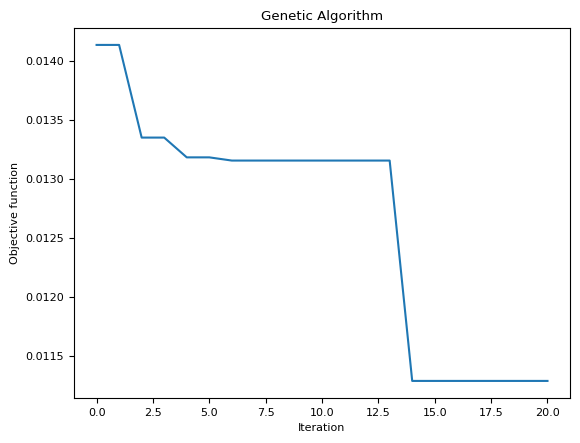

0:	learn: 0.4150905	total: 543us	remaining: 128ms
1:	learn: 0.3839733	total: 1.42ms	remaining: 166ms
2:	learn: 0.3580098	total: 1.82ms	remaining: 142ms
3:	learn: 0.3456319	total: 2.35ms	remaining: 136ms
4:	learn: 0.3277732	total: 2.77ms	remaining: 128ms
5:	learn: 0.2980203	total: 3.55ms	remaining: 136ms
6:	learn: 0.2756021	total: 4.27ms	remaining: 140ms
7:	learn: 0.2561236	total: 4.97ms	remaining: 142ms
8:	learn: 0.2381512	total: 5.77ms	remaining: 145ms
9:	learn: 0.2324731	total: 6.05ms	remaining: 137ms
10:	learn: 0.2206720	total: 6.78ms	remaining: 139ms
11:	learn: 0.2117573	total: 7.53ms	remaining: 141ms
12:	learn: 0.1972526	total: 8.23ms	remaining: 141ms
13:	learn: 0.1826580	total: 8.96ms	remaining: 142ms
14:	learn: 0.1752439	total: 9.72ms	remaining: 143ms
15:	learn: 0.1635041	total: 10.4ms	remaining: 143ms
16:	learn: 0.1536365	total: 11.2ms	remaining: 144ms
17:	learn: 0.1445882	total: 11.9ms	remaining: 145ms
18:	learn: 0.1368827	total: 12.7ms	remaining: 145ms
19:	learn: 0.1324023	to

In [15]:
def fitness_function(params):
    iterations = int(params[0])
    learning_rate = params[1]
    depth = int(params[2])
    l2_leaf_reg = params[3]

    model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, random_seed=0)

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

    outer_mses = []

    for outer_train_index, outer_test_index in outer_cv.split(X):
        outer_train_X, outer_test_X = X.iloc[outer_train_index], X.iloc[outer_test_index]
        outer_train_y, outer_test_y = y.iloc[outer_train_index], y.iloc[outer_test_index]
        
        inner_mses = []

        for inner_train_index, inner_val_index in inner_cv.split(outer_train_X):
            inner_train_X, inner_val_X = outer_train_X.iloc[inner_train_index], outer_train_X.iloc[inner_val_index]
            inner_train_y, inner_val_y = outer_train_y.iloc[inner_train_index], outer_train_y.iloc[inner_val_index]

            model.fit(inner_train_X, inner_train_y, verbose=False)
            inner_y_pred = model.predict(inner_val_X)
            inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
            inner_mses.append(inner_mse)

        model.fit(outer_train_X, outer_train_y, verbose=False)
        outer_y_pred = model.predict(outer_test_X)
        outer_mse = mean_squared_error(outer_test_y, outer_y_pred)
        outer_mses.append(outer_mse)

    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[10, 300], [0.01, 0.3], [3, 10], [1, 5]])
vartype = np.array([['int'], ['real'], ['int'], ['real']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=4, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None}, function_timeout=150.0)

    solver.run()
    best_params = {
        "iterations": int(solver.output_dict['variable'][0]),
        "learning_rate": solver.output_dict['variable'][1],
        "depth": int(solver.output_dict['variable'][2]),
        "l2_leaf_reg": solver.output_dict['variable'][3]
    }

    # Train and test the model with the best parameters found in this simulation
    model = CatBoostRegressor(**best_params, random_seed=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_model_CatBoostRegressor = CatBoostRegressor(**best_model_params, random_state=0)
final_model_CatBoostRegressor.fit(X_train, y_train)
y_pred = final_model_CatBoostRegressor.predict(X_test)
mse_final_CatBoostRegressor = mean_squared_error(y_test, y_pred)
rmse_final_CatBoostRegressor = np.sqrt(mse_final)
r2_final_CatBoostRegressor = r2_score(y_test, y_pred)

# Save the best model
final_model_CatBoostRegressor.save_model('best_model.cbm')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")
    
best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_catboost.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_catboost.csv', index=False)

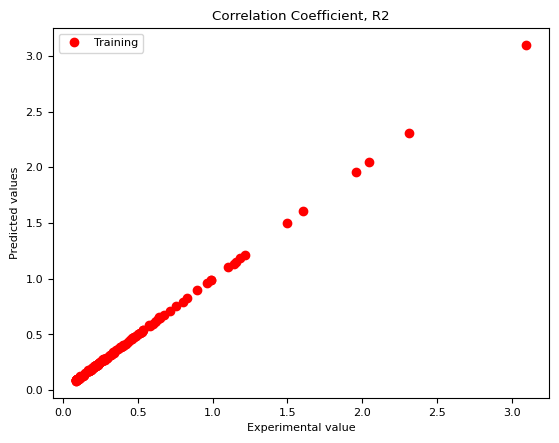

Train RMSE: 0.0037918222430950413
Train R2: 0.9999276607378684


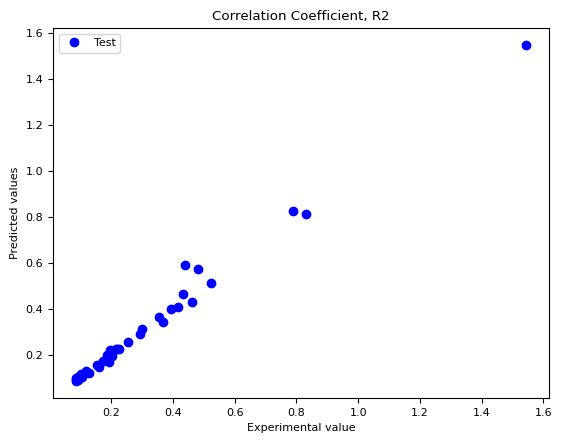

Test RMSE: 0.03255251077000524
Test R2: 0.9862612921838988


In [16]:
import catboost

# Create an instance of CatBoostRegressor
loaded_model = catboost.CatBoostRegressor()

# Load the model from the file
loaded_model.load_model('best_model.cbm')
y_predtst = loaded_model.predict(X_test)
y_predtrn = loaded_model.predict(X_train)
# Now you can use loaded_model to make predictions, etc.

# Make predictions on the test set using the best model
#y_predtst = final_model_CatBoostRegressor.predict(X_test)
#y_predtrn = final_model_CatBoostRegressor.predict(X_train)
# Calculate root mean squared error (RMSE) using the best model

rmse_train_CatBoostRegressor = np.sqrt(mean_squared_error(y_train, y_predtrn))
#print("Train RMSE:", rmse_train)
r2_train_CatBoostRegressor = r2_score(y_train, y_predtrn)
mse_train_CatBoostRegressor = mean_squared_error(y_train, y_predtrn)
#print("Train R2:", r2_train)

rmse_test_CatBoostRegressor = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_CatBoostRegressor = mean_squared_error(y_test, y_predtst)
#print("Test RMSE:", rmse_test)

# Calculate R-squared using the best model
r2_test_CatBoostRegressor = r2_score(y_test, y_predtst)
#print("Test R2:", r2_test)

plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_CatBoostRegressor)
print("Train R2:", r2_train_CatBoostRegressor)

plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_CatBoostRegressor)
print("Test R2:", r2_test_CatBoostRegressor)

In [17]:
from sklearn.linear_model import Lasso

 The best solution found:                                                                           
 [0.01005347 0.00777503]

 Objective function:
 0.1537413534191277


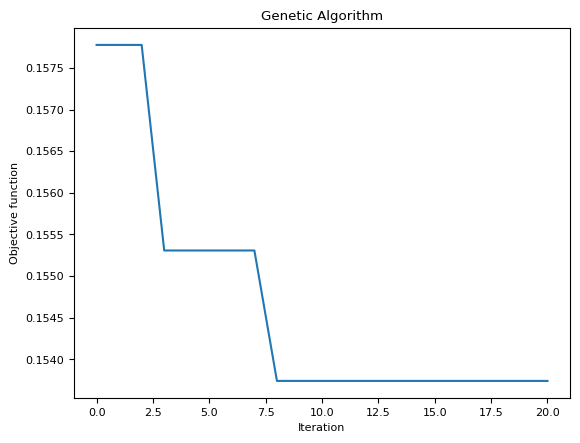

Best Hyper-parameters:
alpha: 0.010053471800728743
tol: 0.007775032362893137


In [18]:
def fitness_function(params):
    alpha = params[0]
    tol = params[1]
    
    model = Lasso(alpha=alpha, tol=tol, random_state=0)
    
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

    outer_mses = []

    for outer_train_index, outer_test_index in outer_cv.split(X):
        outer_train_X, outer_test_X = X.iloc[outer_train_index], X.iloc[outer_test_index]
        outer_train_y, outer_test_y = y.iloc[outer_train_index], y.iloc[outer_test_index]
        
        inner_mses = []

        for inner_train_index, inner_val_index in inner_cv.split(outer_train_X):
            inner_train_X, inner_val_X = outer_train_X.iloc[inner_train_index], outer_train_X.iloc[inner_val_index]
            inner_train_y, inner_val_y = outer_train_y.iloc[inner_train_index], outer_train_y.iloc[inner_val_index]

            model.fit(inner_train_X, inner_train_y)
            inner_y_pred = model.predict(inner_val_X)
            inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
            inner_mses.append(inner_mse)

        model.fit(outer_train_X, outer_train_y)
        outer_y_pred = model.predict(outer_test_X)
        outer_mse = mean_squared_error(outer_test_y, outer_y_pred)
        outer_mses.append(outer_mse)

    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[0.01, 0.1], [0.001, 0.01]])
vartype = np.array([['real'], ['real']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=2, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None})

    solver.run()
    best_params = {
        "alpha": solver.output_dict['variable'][0],
        "tol": solver.output_dict['variable'][1]
    }

    # Train and test the model with the best parameters found in this simulation
    model = Lasso(**best_params, random_state=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_lasso = Lasso(**best_model_params, random_state=100)
final_lasso.fit(X_train, y_train)
y_pred = final_lasso.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

# Save the best model
from joblib import dump
dump(final_lasso, 'final_lasso.joblib')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")

best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_lasso.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_Lasso.csv', index=False)

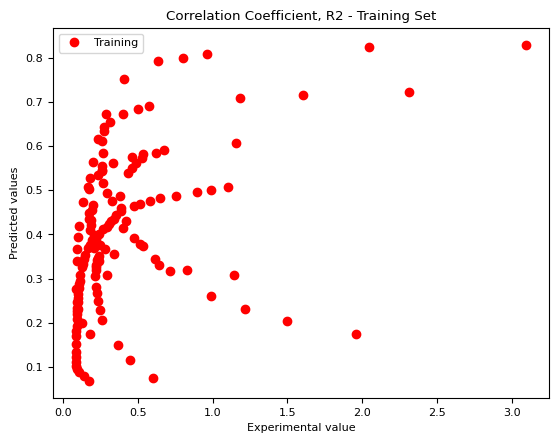

Train RMSE: 0.40438552279000733
Train R2: 0.1772472674302885


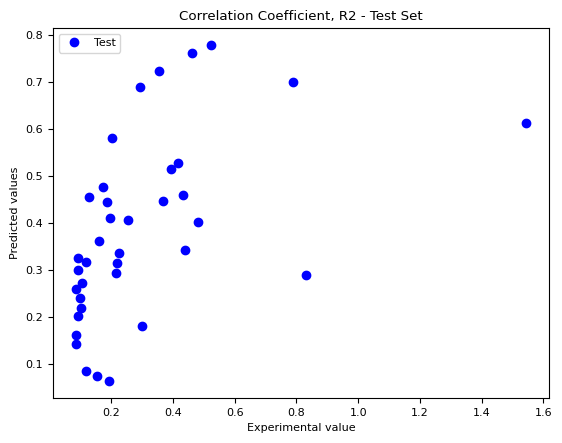

Test RMSE: 0.2605504909383895
Test R2: 0.11984188699125431


In [19]:
import joblib

# Load the model from the file
loaded_lasso_model = joblib.load('final_lasso.joblib')
y_predtst = loaded_lasso_model.predict(X_test)
y_predtrn = loaded_lasso_model.predict(X_train)

# Make predictions on the test set using the best model
#y_predtst = final_lasso.predict(X_test)
#y_predtrn = final_lasso.predict(X_train)

# Calculate root mean squared error (RMSE) using the best model
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_predtrn))
r2_train_lasso = r2_score(y_train, y_predtrn)
mse_train_lasso = mean_squared_error(y_train, y_predtrn)

rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_lasso= mean_squared_error(y_test, y_predtst)
# Calculate R-squared using the best model
r2_test_lasso = r2_score(y_test, y_predtst)

# Plotting for the train set
plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Training Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_lasso)
print("Train R2:", r2_train_lasso)

# Plotting for the test set
plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Test Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_lasso)
print("Test R2:", r2_test_lasso)

In [20]:
from sklearn.linear_model import ElasticNet

 The best solution found:                                                                           
 [0.01173212 0.18234722]

 Objective function:
 0.148242483296287


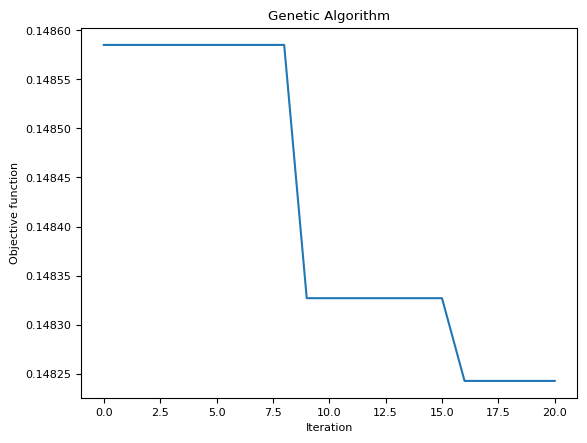

Best Hyper-parameters:
alpha: 0.011732124365022406
l1_ratio: 0.1823472199828625


In [21]:
def fitness_function(params):
    alpha = params[0]
    l1_ratio = params[1]

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=0)

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

    outer_mses = []

    for outer_train_index, outer_test_index in outer_cv.split(X):
        outer_train_X, outer_test_X = X.iloc[outer_train_index], X.iloc[outer_test_index]
        outer_train_y, outer_test_y = y.iloc[outer_train_index], y.iloc[outer_test_index]

        inner_mses = []

        for inner_train_index, inner_val_index in inner_cv.split(outer_train_X):
            inner_train_X, inner_val_X = outer_train_X.iloc[inner_train_index], outer_train_X.iloc[inner_val_index]
            inner_train_y, inner_val_y = outer_train_y.iloc[inner_train_index], outer_train_y.iloc[inner_val_index]

            model.fit(inner_train_X, inner_train_y)
            inner_y_pred = model.predict(inner_val_X)
            inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
            inner_mses.append(inner_mse)

        model.fit(outer_train_X, outer_train_y)
        outer_y_pred = model.predict(outer_test_X)
        outer_mse = mean_squared_error(outer_test_y, outer_y_pred)
        outer_mses.append(outer_mse)

    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[0.01, 0.1], [0.001, 1]])
vartype = np.array([['real'], ['real']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=2, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None})

    solver.run()
    best_params = {
        "alpha": solver.output_dict['variable'][0],
        "l1_ratio": solver.output_dict['variable'][1]
    }

    # Train and test the model with the best parameters found in this simulation
    model = ElasticNet(**best_params, random_state=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_elasticnet = ElasticNet(**best_model_params, random_state=100)
final_elasticnet.fit(X_train, y_train)
y_pred = final_elasticnet.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

# Save the best model
dump(final_elasticnet, 'final_elasticnet.joblib')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")
    
best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_ElasticNet.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_ElasticNet.csv', index=False)

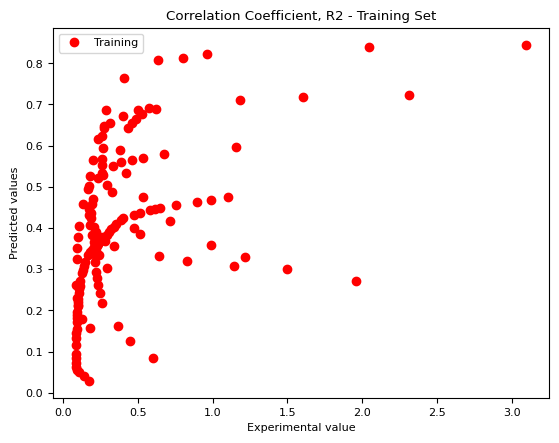

Train RMSE: 0.39477092507536304
Train R2: 0.21590541684971154


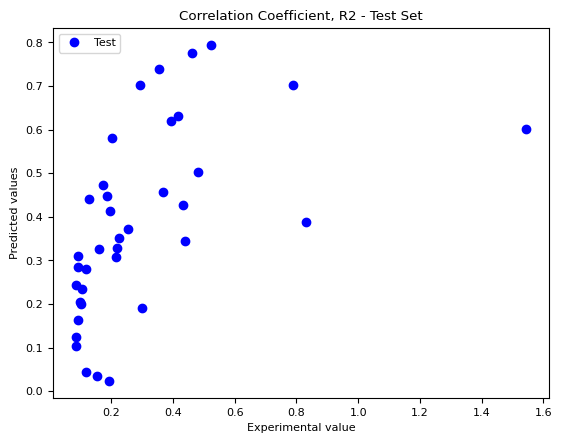

Test RMSE: 0.25829315005166614
Test R2: 0.1350267385629208


In [22]:
# Load the model from the file
loaded_elasticnet_model = joblib.load('final_elasticnet.joblib')
y_predtst = loaded_elasticnet_model.predict(X_test)
y_predtrn = loaded_elasticnet_model.predict(X_train)

# Make predictions on the test set using the best model
#y_predtst = final_elasticnet.predict(X_test)
#y_predtrn = final_elasticnet.predict(X_train)

# Calculate root mean squared error (RMSE) using the best model
rmse_train_elasticnet = np.sqrt(mean_squared_error(y_train, y_predtrn))
r2_train_elasticnet = r2_score(y_train, y_predtrn)
mse_train_elasticnet = mean_squared_error(y_train, y_predtrn)

rmse_test_elasticnet = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_elasticnet = mean_squared_error(y_test, y_predtst)
# Calculate R-squared using the best model
r2_test_elasticnet = r2_score(y_test, y_predtst)

# Plotting for the train set
plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Training Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_elasticnet)
print("Train R2:", r2_train_elasticnet)

# Plotting for the test set
plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Test Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_elasticnet)
print("Test R2:", r2_test_elasticnet)

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

 The best solution found:                                                                           
 [5.]

 Objective function:
 0.018306860987883512


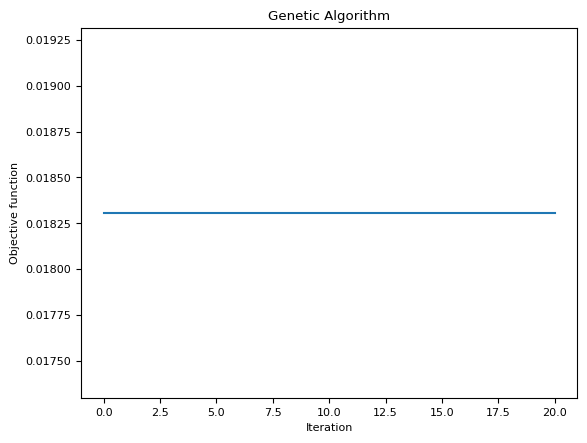

Best Hyper-parameters:
degree: 5


In [24]:
def fitness_function(params):
    degree = int(params[0])

    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

    outer_mses = []

    for outer_train_index, outer_test_index in outer_cv.split(X):
        outer_train_X, outer_test_X = X.iloc[outer_train_index], X.iloc[outer_test_index]
        outer_train_y, outer_test_y = y.iloc[outer_train_index], y.iloc[outer_test_index]

        inner_mses = []

        for inner_train_index, inner_val_index in inner_cv.split(outer_train_X):
            inner_train_X, inner_val_X = outer_train_X.iloc[inner_train_index], outer_train_X.iloc[inner_val_index]
            inner_train_y, inner_val_y = outer_train_y.iloc[inner_train_index], outer_train_y.iloc[inner_val_index]

            model.fit(inner_train_X, inner_train_y)
            inner_y_pred = model.predict(inner_val_X)
            inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
            inner_mses.append(inner_mse)

        model.fit(outer_train_X, outer_train_y)
        outer_y_pred = model.predict(outer_test_X)
        outer_mse = mean_squared_error(outer_test_y, outer_y_pred)
        outer_mses.append(outer_mse)

    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[1, 5]])  # Adjust the range as necessary
vartype = np.array([['int']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=1, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None})

    solver.run()
    best_params = {
        "degree": int(solver.output_dict['variable'][0])
    }

    # Train and test the model with the best parameters found in this simulation
    model = make_pipeline(PolynomialFeatures(degree=best_params['degree']), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
   
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})



# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_polynomial_regression = make_pipeline(PolynomialFeatures(degree=best_model_params['degree']), LinearRegression())
final_polynomial_regression.fit(X_train, y_train)
y_pred = final_polynomial_regression.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

# Save the best model
dump(final_polynomial_regression, 'final_polynomial_regression.joblib')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")

best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_PolynomialRegression.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_PolynomialRegression.csv', index=False)

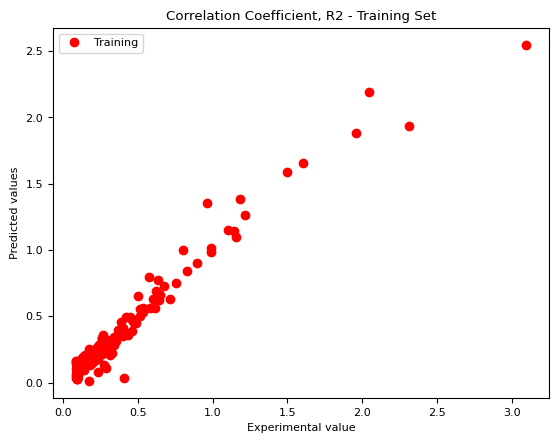

Train RMSE: 0.09492009615670426
Train R2: 0.9546690861934456


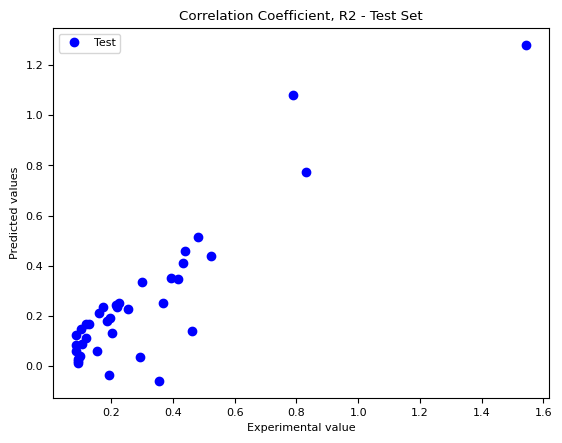

Test RMSE: 0.13031404550340142
Test R2: 0.7798293829509302


In [25]:
# Load the model from the file
loaded_polynomial_regression_model = joblib.load('final_polynomial_regression.joblib')
y_predtst = loaded_polynomial_regression_model.predict(X_test)
y_predtrn = loaded_polynomial_regression_model.predict(X_train)

# Make predictions on the test set using the best model
#y_predtst = final_polynomial_regression.predict(X_test)
#y_predtrn = final_polynomial_regression.predict(X_train)

# Calculate root mean squared error (RMSE) using the best model
rmse_train_polynomial_regression = np.sqrt(mean_squared_error(y_train, y_predtrn))
r2_train_polynomial_regression = r2_score(y_train, y_predtrn)
mse_train_polynomial_regression = mean_squared_error(y_train, y_predtrn)


rmse_test_polynomial_regression = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_polynomial_regression = mean_squared_error(y_test, y_predtst)
# Calculate R-squared using the best model
r2_test_polynomial_regression = r2_score(y_test, y_predtst)

# Plotting for the train set
plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Training Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_polynomial_regression)
print("Train R2:", r2_train_polynomial_regression)

# Plotting for the test set
plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Test Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_polynomial_regression)
print("Test R2:", r2_test_polynomial_regression)

In [26]:
from sklearn.neighbors import KNeighborsRegressor

 The best solution found:                                                                           
 [3. 1.]

 Objective function:
 0.07314794767248933


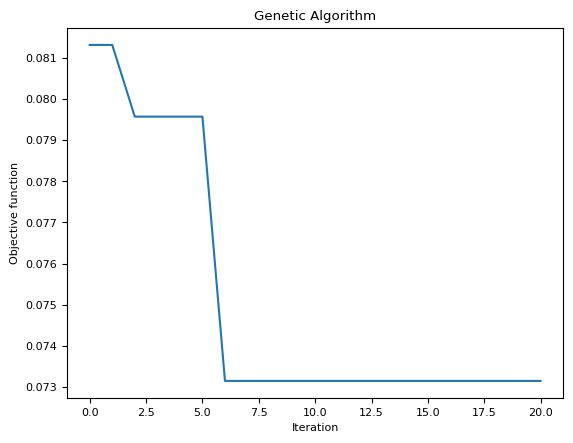

Best Hyper-parameters:
n_neighbors: 3
p: 1


In [27]:
def fitness_function(params):
    n_neighbors = int(params[0])
    p = int(params[1])

    model = KNeighborsRegressor(n_neighbors=n_neighbors, p=p)

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

    outer_mses = []

    for outer_train_index, outer_test_index in outer_cv.split(X):
        outer_train_X, outer_test_X = X.iloc[outer_train_index], X.iloc[outer_test_index]
        outer_train_y, outer_test_y = y.iloc[outer_train_index], y.iloc[outer_test_index]

        inner_mses = []

        for inner_train_index, inner_val_index in inner_cv.split(outer_train_X):
            inner_train_X, inner_val_X = outer_train_X.iloc[inner_train_index], outer_train_X.iloc[inner_val_index]
            inner_train_y, inner_val_y = outer_train_y.iloc[inner_train_index], outer_train_y.iloc[inner_val_index]

            model.fit(inner_train_X, inner_train_y)
            inner_y_pred = model.predict(inner_val_X)
            inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
            inner_mses.append(inner_mse)

        model.fit(outer_train_X, outer_train_y)
        outer_y_pred = model.predict(outer_test_X)
        outer_mse = mean_squared_error(outer_test_y, outer_y_pred)
        outer_mses.append(outer_mse)

    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[1, 20], [1, 5]])
vartype = np.array([['int'], ['int']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=2, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None})

    solver.run()
    best_params = {
        "n_neighbors": int(solver.output_dict['variable'][0]),
        "p": int(solver.output_dict['variable'][1])
    }

    # Train and test the model with the best parameters found in this simulation
    model = KNeighborsRegressor(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_knn = KNeighborsRegressor(**best_model_params)
final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

# Save the best model
dump(final_knn, 'final_knn.joblib')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")

best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_KNN.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_KNN.csv', index=False)

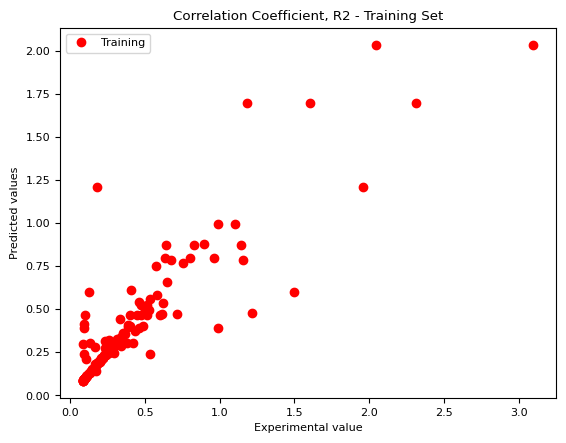

Train RMSE: 0.2112107582572745
Train R2: 0.7755548597802284


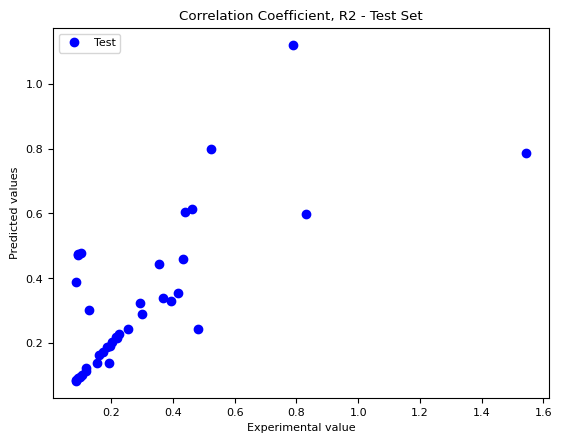

Test RMSE: 0.20129289267739323
Test R2: 0.4746680839700931


In [28]:
# Load the model from the file
loaded_knn_model = joblib.load('final_knn.joblib')
y_predtst = loaded_knn_model.predict(X_test)
y_predtrn = loaded_knn_model.predict(X_train)

# Make predictions on the test set using the best model
#y_predtst = final_knn.predict(X_test)
#y_predtrn = final_knn.predict(X_train)

# Calculate root mean squared error (RMSE) using the best model
rmse_train_knn = np.sqrt(mean_squared_error(y_train, y_predtrn))
r2_train_knn = r2_score(y_train, y_predtrn)
mse_train_knn = mean_squared_error(y_train, y_predtrn)


rmse_test_knn = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_knn = mean_squared_error(y_test, y_predtst)
# Calculate R-squared using the best model
r2_test_knn = r2_score(y_test, y_predtst)

# Plotting for the train set
plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Training Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_knn)
print("Train R2:", r2_train_knn)

# Plotting for the test set
plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Test Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_knn)
print("Test R2:", r2_test_knn)

In [29]:
from sklearn.ensemble import RandomForestRegressor

 The best solution found:                                                                           
 [426.  51.   3.   2.]

 Objective function:
 0.09027423843707086


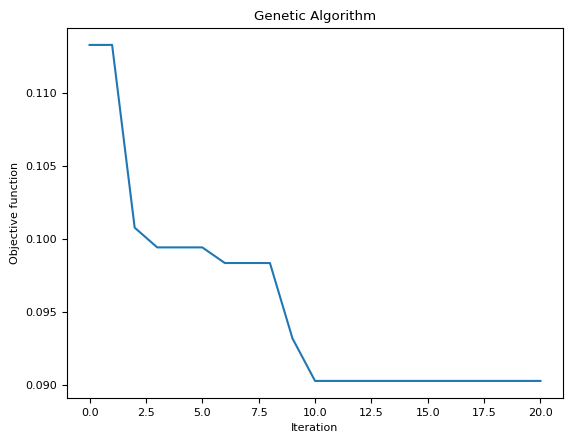

Best Hyper-parameters:
n_estimators: 426
max_depth: 51
min_samples_split: 3
min_samples_leaf: 2


In [30]:
def cv_fold(params, train_index, test_index, X, y):
    n_estimators, max_depth, min_samples_split, min_samples_leaf = map(int, params)
    
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, random_state=0)
    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_mses = []
    
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]

    for inner_train_index, inner_val_index in inner_cv.split(train_X):
        inner_train_X, inner_val_X = train_X.iloc[inner_train_index], train_X.iloc[inner_val_index]
        inner_train_y, inner_val_y = train_y.iloc[inner_train_index], train_y.iloc[inner_val_index]
        
        model.fit(inner_train_X, inner_train_y)
        inner_y_pred = model.predict(inner_val_X)
        
        inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
        inner_mses.append(inner_mse)
        
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    
    mse = mean_squared_error(test_y, y_pred)
    
    return np.mean(inner_mses) + mse

def fitness_function(params):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_mses = Parallel(n_jobs=-1)(delayed(cv_fold)(params, train_index, test_index, X, y) for train_index, test_index in outer_cv.split(X))
    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[50, 600], [10, 100], [2, 20], [1, 10]])
vartype = np.array([['int'], ['int'], ['int'], ['int']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=4, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None},
                function_timeout=150.0)

    solver.run()
    best_params = {
        "n_estimators": int(solver.output_dict['variable'][0]),
        "max_depth": int(solver.output_dict['variable'][1]),
        "min_samples_split": int(solver.output_dict['variable'][2]),
        "min_samples_leaf": int(solver.output_dict['variable'][3])
    }

    # Train and test the model with the best parameters found in this simulation
    model = RandomForestRegressor(**best_params, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_random_forest = RandomForestRegressor(**best_model_params, random_state=0)
final_random_forest.fit(X_train, y_train)
y_pred = final_random_forest.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

# Save the best model
dump(final_random_forest, 'final_random_forest.joblib')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")

best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_RandomForest.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_RandomForest.csv', index=False)


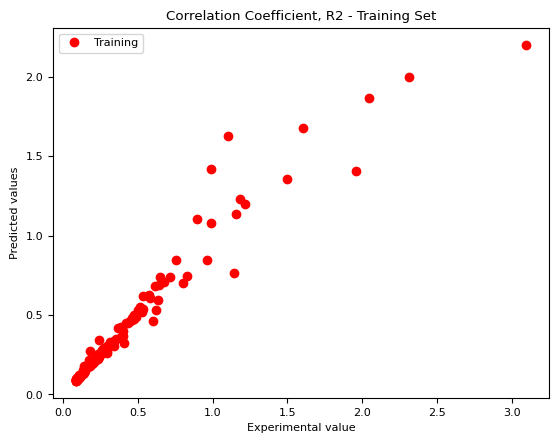

Train RMSE: 0.1193534445574567
Train R2: 0.9283282432593418


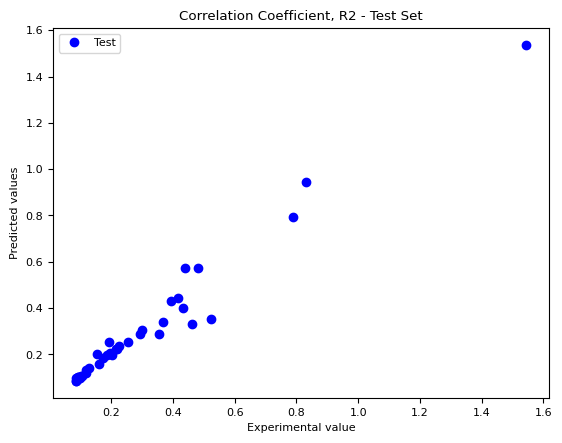

Test RMSE: 0.05205652231146781
Test R2: 0.9648660315149267


In [31]:
# Load the model from the file
loaded_random_forest_model = joblib.load('final_random_forest.joblib')
y_predtst = loaded_random_forest_model.predict(X_test)
y_predtrn = loaded_random_forest_model.predict(X_train)

# Make predictions on the test set using the best model
#y_predtst = final_random_forest.predict(X_test)
#y_predtrn = final_random_forest.predict(X_train)

# Calculate root mean squared error (RMSE) using the best model
rmse_train_random_forest = np.sqrt(mean_squared_error(y_train, y_predtrn))
r2_train_random_forest = r2_score(y_train, y_predtrn)
mse_train_random_forest = mean_squared_error(y_train, y_predtrn)


rmse_test_random_forest = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_random_forest = mean_squared_error(y_test, y_predtst)
# Calculate R-squared using the best model
r2_test_random_forest = r2_score(y_test, y_predtst)

# Plotting for the train set
plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Training Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_random_forest)
print("Train R2:", r2_train_random_forest)

# Plotting for the test set
plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Test Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_random_forest)
print("Test R2:", r2_test_random_forest)

In [32]:
from sklearn.tree import DecisionTreeRegressor

 The best solution found:                                                                           
 [12.  2.  1.]

 Objective function:
 0.07760340824774664


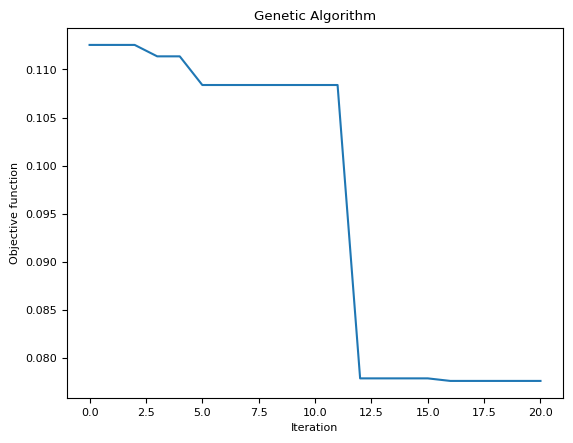

Best Hyper-parameters:
max_depth: 12
min_samples_split: 2
min_samples_leaf: 1


In [33]:
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd

def cv_fold(params, train_index, test_index, X, y):
    max_depth, min_samples_split, min_samples_leaf = map(int, params)
    
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, random_state=0)
    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_mses = []
    
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]

    for inner_train_index, inner_val_index in inner_cv.split(train_X):
        inner_train_X, inner_val_X = train_X.iloc[inner_train_index], train_X.iloc[inner_val_index]
        inner_train_y, inner_val_y = train_y.iloc[inner_train_index], train_y.iloc[inner_val_index]
        
        model.fit(inner_train_X, inner_train_y)
        inner_y_pred = model.predict(inner_val_X)
        
        inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
        inner_mses.append(inner_mse)
        
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    
    mse = mean_squared_error(test_y, y_pred)
    
    return np.mean(inner_mses) + mse

def fitness_function(params):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_mses = Parallel(n_jobs=-1)(delayed(cv_fold)(params, train_index, test_index, X, y) for train_index, test_index in outer_cv.split(X))
    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[1, 40], [2, 10], [1, 10]])
vartype = np.array([['int'], ['int'], ['int']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=3, variable_type_mixed=vartype, variable_boundaries=varbound,
                algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                      'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                      'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                      'mutation_type': 'random', 'max_iteration_without_improv': None})

    solver.run()
    best_params = {
        "max_depth": int(solver.output_dict['variable'][0]),
        "min_samples_split": int(solver.output_dict['variable'][1]),
        "min_samples_leaf": int(solver.output_dict['variable'][2])
    }

    # Train and test the model with the best parameters found in this simulation
    model = DecisionTreeRegressor(**best_params, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_decision_tree = DecisionTreeRegressor(**best_model_params, random_state=0)
final_decision_tree.fit(X_train, y_train)
y_pred = final_decision_tree.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

# Save the best model
dump(final_decision_tree, 'final_decision_tree.joblib')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")

best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_DecisionTree.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_DecisionTree.csv', index=False)

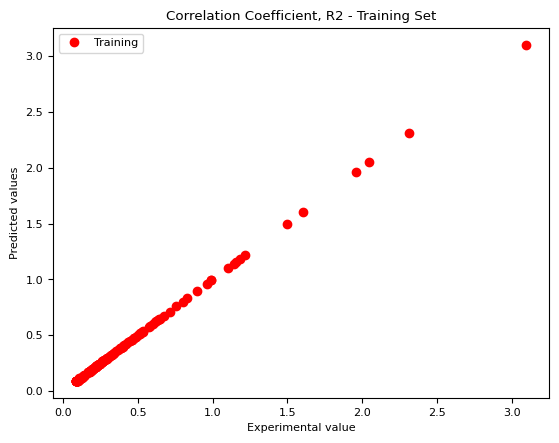

Train RMSE: 0.002294092025228752
Train R2: 0.9999735211081783


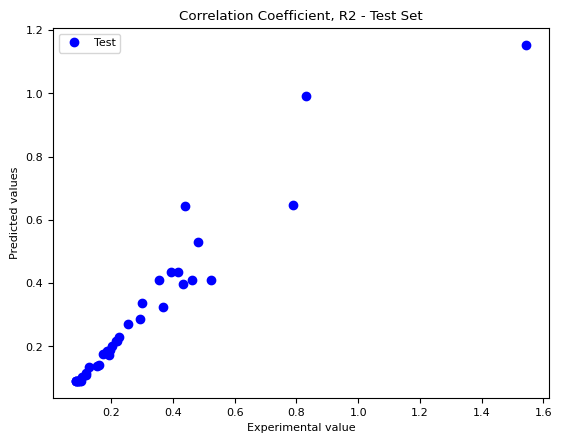

Test RMSE: 0.0856164628224512
Test R2: 0.9049632737765816


In [34]:
# Load the model from the file
loaded_decision_tree_model = joblib.load('final_decision_tree.joblib')
y_predtst = loaded_decision_tree_model.predict(X_test)
y_predtrn = loaded_decision_tree_model.predict(X_train)

# Make predictions on the test set using the best model
#y_predtst = final_decision_tree.predict(X_test)
#y_predtrn = final_decision_tree.predict(X_train)

# Calculate root mean squared error (RMSE) using the best model
rmse_train_decision_tree = np.sqrt(mean_squared_error(y_train, y_predtrn))
r2_train_decision_tree = r2_score(y_train, y_predtrn)
mse_train_decision_tree = mean_squared_error(y_train, y_predtrn)


rmse_test_decision_tree = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_decision_tree = mean_squared_error(y_test, y_predtst)
# Calculate R-squared using the best model
r2_test_decision_tree = r2_score(y_test, y_predtst)

# Plotting for the train set
plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Training Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_decision_tree)
print("Train R2:", r2_train_decision_tree)

# Plotting for the test set
plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Test Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_decision_tree)
print("Test R2:", r2_test_decision_tree)

In [35]:
from sklearn.ensemble import BaggingRegressor

 The best solution found:                                                                           
 [ 3.         48.          0.99929454]

 Objective function:
 0.044451075758919774


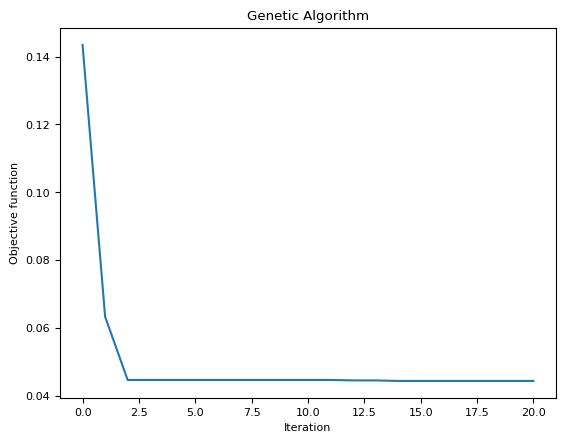

Best Hyper-parameters:
degree: 3
n_estimators: 48
max_samples: 0.999294538954812


In [36]:
def fitness_function(params):
    degree = int(params[0])
    n_estimators = int(params[1])
    max_samples = params[2]

    model = BaggingRegressor(base_estimator=make_pipeline(PolynomialFeatures(degree=degree), LinearRegression()), 
                             n_estimators=n_estimators, 
                             max_samples=max_samples, 
                             random_state=0)

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

    outer_mses = []

    for outer_train_index, outer_test_index in outer_cv.split(X):
        outer_train_X, outer_test_X = X.iloc[outer_train_index], X.iloc[outer_test_index]
        outer_train_y, outer_test_y = y.iloc[outer_train_index], y.iloc[outer_test_index]

        inner_mses = []

        for inner_train_index, inner_val_index in inner_cv.split(outer_train_X):
            inner_train_X, inner_val_X = outer_train_X.iloc[inner_train_index], outer_train_X.iloc[inner_val_index]
            inner_train_y, inner_val_y = outer_train_y.iloc[inner_train_index], outer_train_y.iloc[inner_val_index]

            model.fit(inner_train_X, inner_train_y)
            inner_y_pred = model.predict(inner_val_X)
            inner_mse = mean_squared_error(inner_val_y, inner_y_pred)
            inner_mses.append(inner_mse)

        model.fit(outer_train_X, outer_train_y)
        outer_y_pred = model.predict(outer_test_X)
        outer_mse = mean_squared_error(outer_test_y, outer_y_pred)
        outer_mses.append(outer_mse)

    return np.mean(outer_mses)

# Define the variable bounds and types
varbound = np.array([[1, 5], [10, 100], [0.1, 1.0]])  # Adjust the range as necessary
vartype = np.array([['int'], ['int'], ['real']])

results = []
num_simulations = 1

for sim in range(num_simulations):
    solver = ga(function=fitness_function, dimension=3, variable_type_mixed=vartype, variable_boundaries=varbound,
            algorithm_parameters={'max_num_iteration': 20, 'population_size': 10, 'mutation_probability': 0.8, 
                                 'elit_ratio': 0.02, 'crossover_probability': 0.9, 'parents_portion': 0.3, 
                                 'selection_type': 'roulette', 'crossover_type': 'two_point', 
                                 'mutation_type': 'random', 'max_iteration_without_improv': None}, 
            function_timeout=150.0)
    
    solver.run()
    best_params = {
        "degree": int(solver.output_dict['variable'][0]),
        "n_estimators": int(solver.output_dict['variable'][1]),
        "max_samples": solver.output_dict['variable'][2]
    }

    # Train and test the model with the best parameters found in this simulation
    model = BaggingRegressor(base_estimator=make_pipeline(PolynomialFeatures(degree=best_params['degree']), LinearRegression()), 
                             n_estimators=best_params['n_estimators'], 
                             max_samples=best_params['max_samples'], 
                             random_state=0)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)
    results.append({"mse": mse_value, "rmse": rmse_value, "r2": r2_value, "params": best_params})

# Select the most accurate model
results_df = pd.DataFrame(results)
best_model_index = results_df['mse'].idxmin()
best_model_params = results_df.iloc[best_model_index]['params']

# After obtaining the best parameters:
final_bagging = BaggingRegressor(base_estimator=make_pipeline(PolynomialFeatures(degree=best_model_params['degree']), LinearRegression()), 
                               n_estimators=best_model_params['n_estimators'], 
                               max_samples=best_model_params['max_samples'], 
                               random_state=0)

final_bagging.fit(X_train, y_train)
y_pred = final_bagging.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

# Save the best model
dump(final_bagging, 'final_bagging.joblib')

print("Best Hyper-parameters:")
for key, value in best_model_params.items():
    print(f"{key}: {value}")

best_params_df = pd.DataFrame([best_model_params])
best_params_df.to_csv('best_hyperparameters_bagging.csv', index=False)

# Saving results to CSV
results_df.to_csv('simulation_results_bagging.csv', index=False)

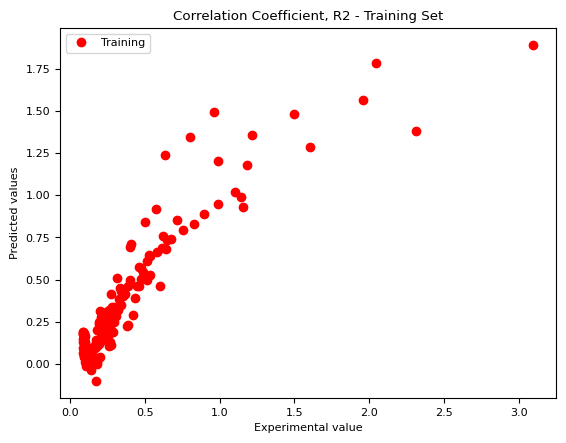

Train RMSE: 0.18632415098399427
Train R2: 0.8253307574842831


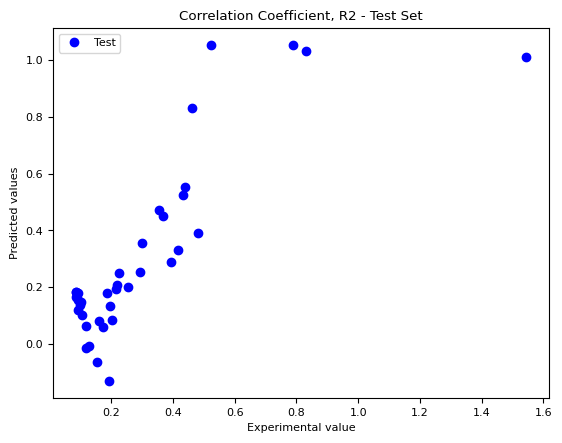

Test RMSE: 0.17726780474791165
Test R2: 0.5925853533808876


In [37]:
# Load the model from the file
loaded_bagging_model = joblib.load('final_bagging.joblib')
y_predtst = loaded_bagging_model.predict(X_test)
y_predtrn = loaded_bagging_model.predict(X_train)


# Make predictions on the test set using the best model
#y_predtst = final_bagging.predict(X_test)
#y_predtrn = final_bagging.predict(X_train)

# Calculate root mean squared error (RMSE) using the best model
rmse_train_bagging = np.sqrt(mean_squared_error(y_train, y_predtrn))
r2_train_bagging = r2_score(y_train, y_predtrn)
mse_train_bagging = mean_squared_error(y_train, y_predtrn)


rmse_test_bagging = np.sqrt(mean_squared_error(y_test, y_predtst))
mse_test_bagging = mean_squared_error(y_test, y_predtst)
# Calculate R-squared using the best model
r2_test_bagging = r2_score(y_test, y_predtst)

# Plotting for the train set
plt.plot(y_train, y_predtrn, 'ro', label='Training')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Training Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Train RMSE:", rmse_train_bagging)
print("Train R2:", r2_train_bagging)

# Plotting for the test set
plt.plot(y_test, y_predtst, 'bo', label='Test')
#plt.plot([0,1500000000], [0,1500000000], 'k-')

plt.title('Correlation Coefficient, R2 - Test Set')
plt.xlabel('Experimental value')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()
print("Test RMSE:", rmse_test_bagging)
print("Test R2:", r2_test_bagging)

In [38]:
# Load the best hyperparameters from the respective CSV files
best_hyperparameters_lasso = pd.read_csv('best_hyperparameters_lasso.csv')
best_hyperparameters_elastic_net = pd.read_csv('best_hyperparameters_ElasticNet.csv')
best_hyperparameters_polynomial_regression = pd.read_csv('best_hyperparameters_PolynomialRegression.csv')
best_hyperparameters_knn = pd.read_csv('best_hyperparameters_KNN.csv')
best_hyperparameters_random_forest = pd.read_csv('best_hyperparameters_RandomForest.csv')
best_hyperparameters_decision_tree = pd.read_csv('best_hyperparameters_DecisionTree.csv')
best_hyperparameters_bagging = pd.read_csv('best_hyperparameters_bagging.csv')
best_hyperparameters_catboost = pd.read_csv('best_hyperparameters_catboost.csv')

# Combine all the dataframes into a single dataframe
best_hyperparameters_all = pd.concat([
    best_hyperparameters_lasso.assign(Model="Lasso"),
    best_hyperparameters_elastic_net.assign(Model="ElasticNet"),
    best_hyperparameters_polynomial_regression.assign(Model="Polynomial Regression"),
    best_hyperparameters_knn.assign(Model="KNN"),
    best_hyperparameters_decision_tree.assign(Model="Decision Tree"),
    best_hyperparameters_random_forest.assign(Model="Random Forest"),
    best_hyperparameters_bagging.assign(Model="Bagging"),
    best_hyperparameters_catboost.assign(Model="CatBoost")
], ignore_index=True)

# Set the model names as the index
best_hyperparameters_all.set_index('Model', inplace=True)

# Display the table
display(best_hyperparameters_all)

# Convert the DataFrame to a LaTeX table and display it
latex_table = best_hyperparameters_all.to_latex()
print(latex_table)

,alpha,tol,l1_ratio,degree,n_neighbors,p,max_depth,min_samples_split,min_samples_leaf,n_estimators,max_samples,iterations,learning_rate,depth,l2_leaf_reg
Model,,,,,,,,,,,,,,,
Lasso,0.010053,0.007775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ElasticNet,0.011732,NaN,0.182347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Polynomial Regression,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN,NaN,12.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN,NaN,51.0,3.0,2.0,426.0,NaN,NaN,NaN,NaN,NaN
Bagging,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,48.0,0.999295,NaN,NaN,NaN,NaN
CatBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.0,0.155434,6.0,1.183762


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
 & alpha & tol & l1_ratio & degree & n_neighbors & p & max_depth & min_samples_split & min_samples_leaf & n_estimators & max_samples & iterations & learning_rate & depth & l2_leaf_reg \\
Model &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Lasso & 0.010053 & 0.007775 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
ElasticNet & 0.011732 & NaN & 0.182347 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
Polynomial Regression & NaN & NaN & NaN & 5.000000 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
KNN & NaN & NaN & NaN & NaN & 3.000000 & 1.000000 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
Decision Tree & NaN & NaN & NaN & NaN & NaN & NaN & 12.000000 & 2.000000 & 1.000000 & NaN & NaN & NaN & NaN & NaN & NaN \\
Random Forest & NaN & NaN & NaN & NaN & NaN & NaN & 51.000000 & 3.000000 & 2.000000 & 426.000000 & NaN & NaN & NaN & NaN & NaN \\
Bagg

\begin{tabular}{lrrrrrr}
\toprule
 Model    &   R2 Train &   MSE Train &   RMSE Train &   R2 Test &    MSE Test &   RMSE Test \\
\midrule
 Lasso    &   0.177247 & 1.63528e-27 &  4.04386e-14 &  0.119842 & 6.78866e-28 & 2.6055e-14  \\
 ENet     &   0.215905 & 1.55844e-27 &  3.94771e-14 &  0.135027 & 6.67154e-28 & 2.58293e-14 \\
 Poly     &   0.954669 & 9.00982e-29 &  9.49201e-15 &  0.779829 & 1.69818e-28 & 1.30314e-14 \\
 KNN      &   0.775555 & 4.461e-28   &  2.11211e-14 &  0.474668 & 4.05188e-28 & 2.01293e-14 \\
 DT       &   0.999974 & 5.26286e-32 &  2.29409e-16 &  0.904963 & 7.33018e-29 & 8.56165e-15 \\
 RF       &   0.928328 & 1.42452e-28 &  1.19353e-14 &  0.964866 & 2.70988e-29 & 5.20565e-15 \\
 Bag      &   0.825331 & 3.47167e-28 &  1.86324e-14 &  0.592585 & 3.14239e-28 & 1.77268e-14 \\
 CatBoost &   0.999928 & 1.43779e-31 &  3.79182e-16 &  0.986261 & 1.05967e-29 & 3.25525e-15 \\
\bottomrule
\end{tabular}


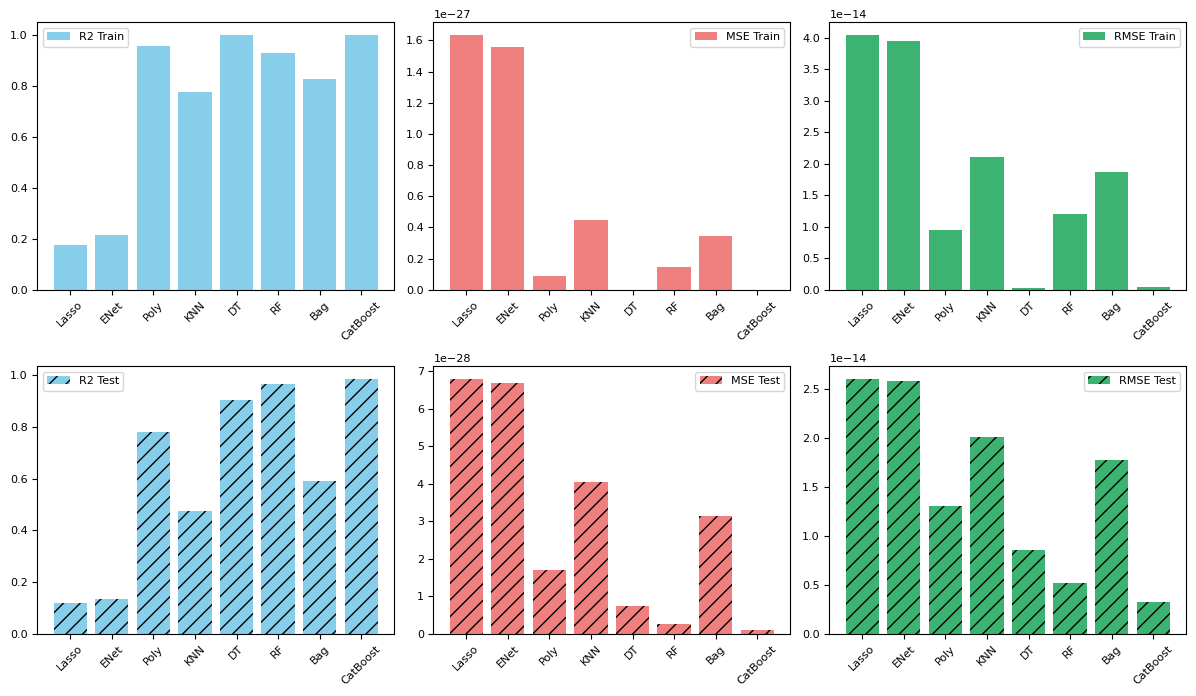

In [39]:
# List of models
models = [loaded_lasso_model, loaded_elasticnet_model, loaded_polynomial_regression_model, loaded_knn_model, loaded_decision_tree_model,
         loaded_random_forest_model, loaded_bagging_model, loaded_model]

#models = [final_lasso, final_elasticnet, final_polynomial_regression, final_knn, 
#          final_random_forest, final_decision_tree, final_bagging, final_model_CatBoostRegressor]

y_pred_train = [model.predict(X_train) * 1e-13 for model in models]

# Adjust true y values
y_train_adj = y_train * 1e-13
y_test_adj = y_test * 1e-13

# Adjust predicted y values for each model and recalculate metrics
# Replace model.predict(X) with model.predict(X) * 1e-13 for each model
y_pred_train = [model.predict(X_train) * 1e-13 for model in models]
y_pred_test = [model.predict(X_test) * 1e-13 for model in models]

r2_train = [r2_score(y_train_adj, pred) for pred in y_pred_train]
mse_train = [mean_squared_error(y_train_adj, pred) for pred in y_pred_train]
rmse_train = [np.sqrt(mse) for mse in mse_train]

r2_test = [r2_score(y_test_adj, pred) for pred in y_pred_test]
mse_test = [mean_squared_error(y_test_adj, pred) for pred in y_pred_test]
rmse_test = [np.sqrt(mse) for mse in mse_test]

# Abbreviated model names:
models_abbr = ['Lasso', 'ENet', 'Poly', 'KNN', 'DT', 'RF', 'Bag', 'CatBoost']

# Bar plot for training and testing metrics
x = np.arange(len(models_abbr))  # the label locations

fig, axs = plt.subplots(2, 3, figsize=(12, 7))  # Adjust figure size

# Plotting metrics for Training
axs[0, 0].bar(x, r2_train, label='R2 Train', color='skyblue')
axs[0, 1].bar(x, mse_train, label='MSE Train', color='lightcoral')
axs[0, 2].bar(x, rmse_train, label='RMSE Train', color='mediumseagreen')

# Plotting metrics for Testing
axs[1, 0].bar(x, r2_test, label='R2 Test', color='skyblue', hatch='//')
axs[1, 1].bar(x, mse_test, label='MSE Test', color='lightcoral', hatch='//')
axs[1, 2].bar(x, rmse_test, label='RMSE Test', color='mediumseagreen', hatch='//')

# Adding labels, and legends
for i in range(3):
    axs[0, i].set_xticks(x)
    axs[1, i].set_xticks(x)
    axs[0, i].set_xticklabels(models_abbr, rotation=45)  # Adjust rotation for better readability
    axs[1, i].set_xticklabels(models_abbr, rotation=45)  # Adjust rotation for better readability
    axs[0, i].legend()
    axs[1, i].legend()

plt.tight_layout()
plt.savefig('metrics.png', bbox_inches='tight')

# Create a DataFrame to hold your data
data = {
    'Model': models_abbr,
    'R2 Train': r2_train,
    'MSE Train': mse_train,
    'RMSE Train': rmse_train,
    'R2 Test': r2_test,
    'MSE Test': mse_test,
    'RMSE Test': rmse_test
}

df = pd.DataFrame(data)

# Convert DataFrame to LaTeX tabular format
latex_table = tabulate(df, tablefmt='latex_booktabs', showindex=False, headers='keys')

# Print the LaTeX table string
print(latex_table)

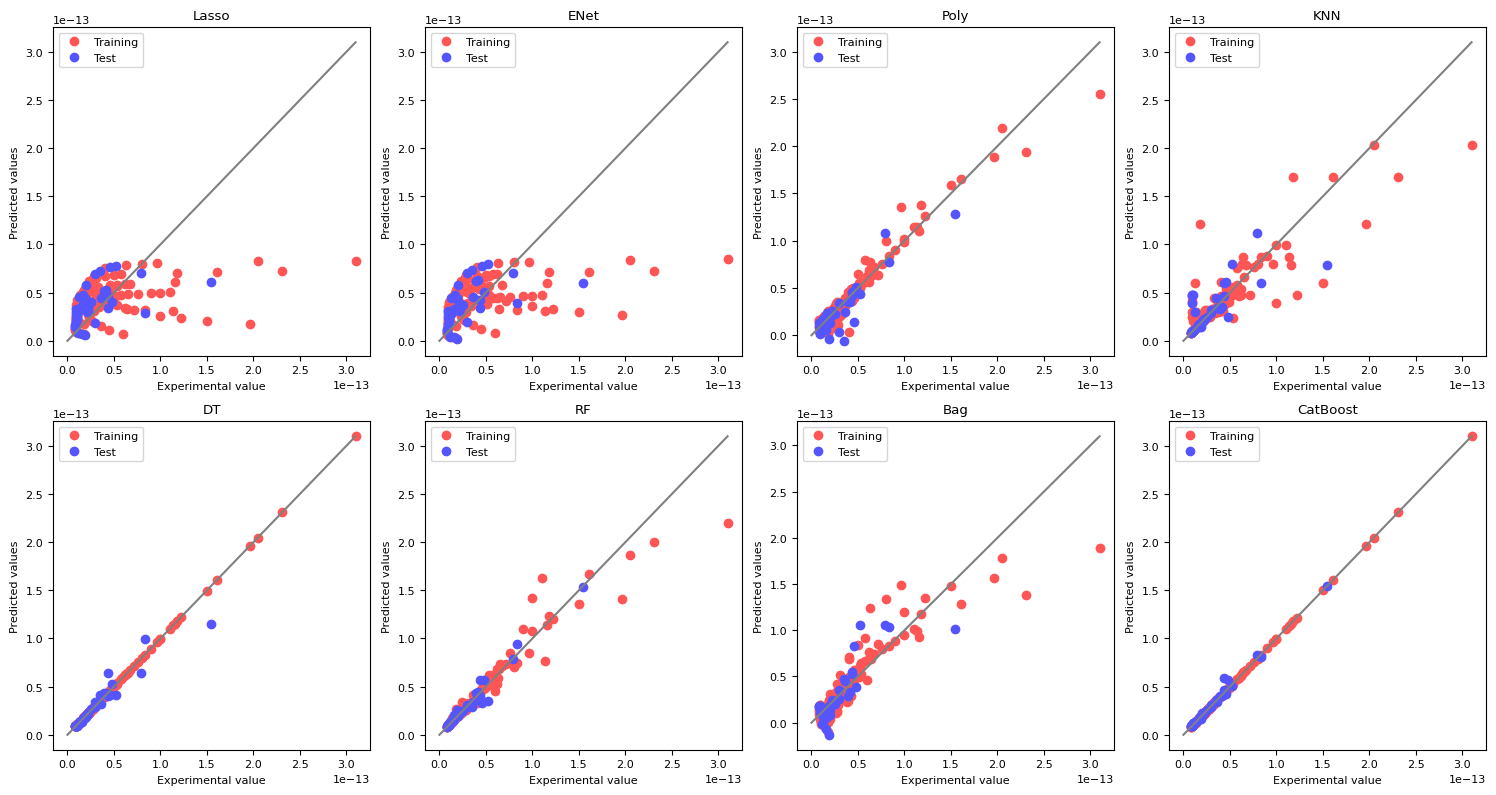

In [40]:
# List of model names
model_names = ['Lasso', 'ENet', 'Poly', 'KNN', 'DT', 'RF', 'Bag', 'CatBoost']

# Create a figure with a smaller size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))  # Adjusted size

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each model, model name, and axis
for model, model_name, ax in zip(models, model_names, axes):
    # Make predictions
    y_predtrn = model.predict(X_train) * 1e-13
    y_predtst = model.predict(X_test) * 1e-13

    # Multiply experimental values by 1e-13
    y_train_scaled = y_train * 1e-13
    y_test_scaled = y_test * 1e-13

    # Find the max value to set the limits of the plot and the 45-degree line
    max_value = max(y_train_scaled.max(), y_predtrn.max(), y_test_scaled.max(), y_predtst.max())

    # Plotting with adjusted colors
    ax.plot(y_train_scaled, y_predtrn, 'ro', color='#FF5555', label='Training')  # Lighter red
    ax.plot(y_test_scaled, y_predtst, 'bo', color='#5555FF', label='Test')  # Lighter blue
    ax.plot([0, max_value], [0, max_value], 'k-', color='grey')  # 45-degree line

    ax.set_title(f'{model_name}')
    ax.set_xlabel('Experimental value')
    ax.set_ylabel('Predicted values')
    ax.legend(loc='upper left')

# Adjust the layout
plt.tight_layout()
plt.savefig('regression.png', bbox_inches='tight')

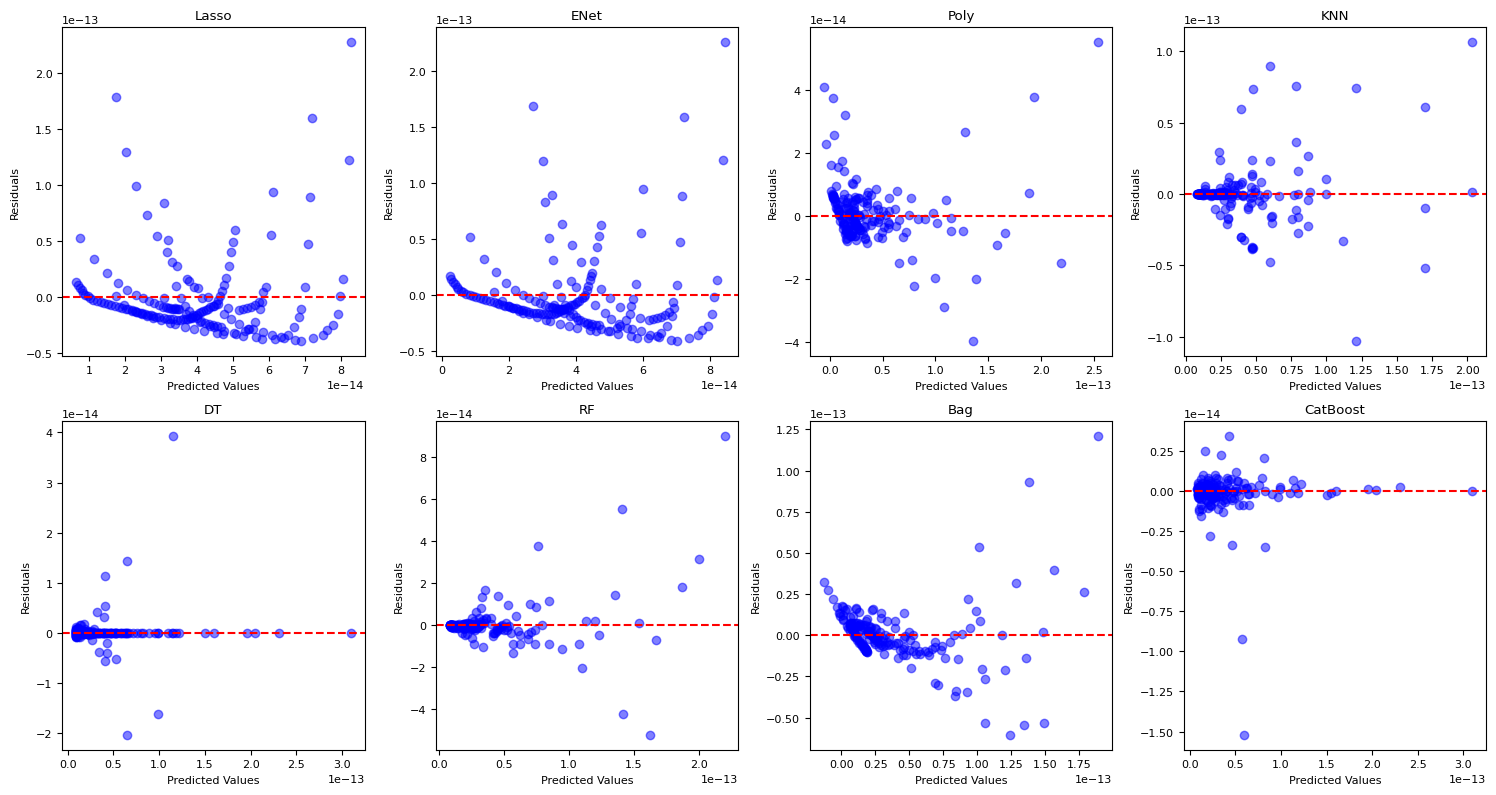

In [41]:
# List of model names
model_names = ['Lasso', 'ENet', 'Poly', 'KNN', 'DT', 'RF', 'Bag', 'CatBoost']

# Create a figure with a smaller size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))  # Adjusted size

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each model, model name, and axis
for model, model_name, ax in zip(models, model_names, axes):
    # Make predictions
    y_predtrn = model.predict(X_train) * 1e-13
    y_predtst = model.predict(X_test) * 1e-13

    # Multiply experimental values by 1e-13
    y_train_scaled = y_train * 1e-13
    y_test_scaled = y_test * 1e-13

    # Calculate residuals
    residuals_train = y_train_scaled - y_predtrn
    residuals_test = y_test_scaled - y_predtst
    
    # Combining the residuals and predictions for plotting
    combined_residuals = np.concatenate((residuals_train, residuals_test))
    combined_predictions = np.concatenate((y_predtrn, y_predtst))
    
    # Plotting residuals vs fitted values
    ax.scatter(combined_predictions, combined_residuals, color='blue', alpha=0.5)
    ax.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at y = 0
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')

# Adjust the layout
plt.tight_layout()
plt.savefig('residual_distribution.png', bbox_inches='tight')

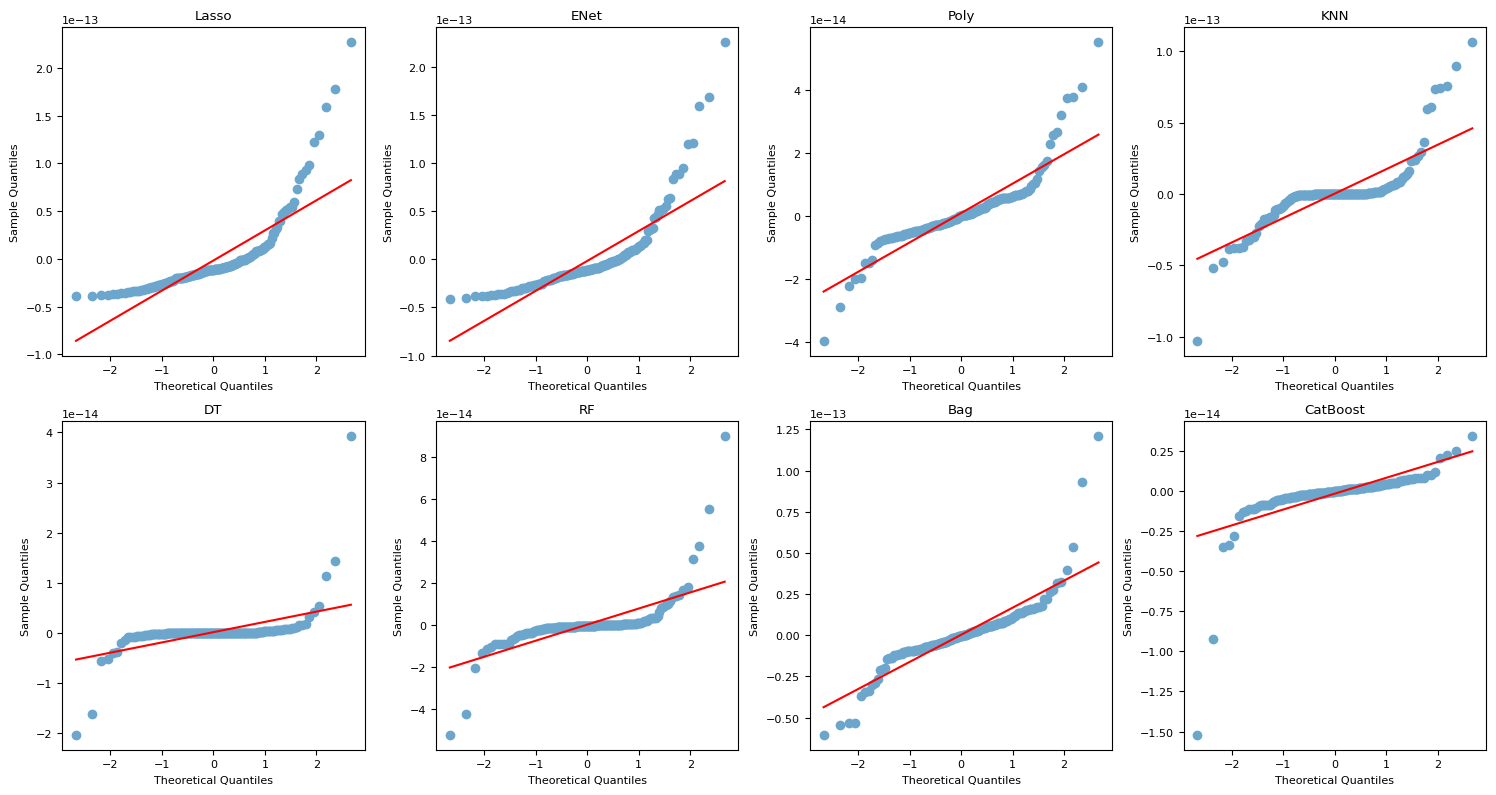

In [42]:
# List of model names
model_names = ['Lasso', 'ENet', 'Poly', 'KNN', 'DT', 'RF', 'Bag', 'CatBoost']

# Create a figure with a smaller size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))  # Adjusted size

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each model, model name, and axis
for model, model_name, ax in zip(models, model_names, axes):
    # Make predictions
    y_predtrn = model.predict(X_train) * 1e-13
    y_predtst = model.predict(X_test) * 1e-13

    # Multiply experimental values by 1e-13
    y_train_scaled = y_train * 1e-13
    y_test_scaled = y_test * 1e-13

    # Calculate residuals
    residuals_train = y_train_scaled - y_predtrn
    residuals_test = y_test_scaled - y_predtst
    
    # Combining the residuals for plotting
    combined_residuals = np.concatenate((residuals_train, residuals_test))
    
    # Creating the Q-Q plot with the same color for line and markers
    (osm, osr), (slope, intercept, r) = stats.probplot(combined_residuals, dist="norm", plot=None)
    ax.plot(osm, osr, 'o', color='#6CA6CD')  # Blue markers
    ax.plot(osm, slope*osm + intercept, color='red')  # Red line
    
    ax.set_title(model_name)  # Set title to model name
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

# Adjust the layout
plt.tight_layout()
plt.show()

In [43]:
from scipy import stats
# Initialize an empty list to collect statistics
summary_statistics = []

# Loop through each model and model name
for model, model_name in zip(models, model_names):
    # ... your existing code ...
    # Combining the residuals for statistics calculation
    combined_residuals = np.concatenate((residuals_train, residuals_test))
    
    # Calculate statistics
    stats_dict = {
        'Model': model_name,
        'Mean': np.mean(combined_residuals),
        'Median': np.median(combined_residuals),
        'Variance': np.var(combined_residuals),
        'Standard Deviation': np.std(combined_residuals),
        'Skewness': stats.skew(combined_residuals),  # Note the prefix stats.
        'Kurtosis': stats.kurtosis(combined_residuals)  # Note the prefix stats.
    }
    summary_statistics.append(stats_dict)

# Convert the list of dictionaries to a DataFrame
summary_df = pd.DataFrame(summary_statistics)

# Display the table in LaTeX format
print(tabulate(summary_df, tablefmt="latex", headers="keys", showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 Model    &         Mean &       Median &    Variance &   Standard Deviation &   Skewness &   Kurtosis \\
\hline
 Lasso    & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
 ENet     & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
 Poly     & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
 KNN      & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
 DT       & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
 RF       & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
 Bag      & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
 CatBoost & -1.73969e-16 & -3.57803e-17 & 2.23855e-30 &          1.49618e-15 &   -6.76608 &    60.8909 \\
\hline
